In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import json
import pickle
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from scipy.stats import randint as sp_randint
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        total = []
        for row in cm:
          s = np.sum(row)
          total.append(s)

        print("Total number of samples for each classs: " + str(total))

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
# Retrieve the target based on the directoie
SOUND_FOLDER = "./Audio_Dataset"
FEAT_FOLDER = "./Features"

### **Data Preparation**

In [4]:
# Load features
path = os.path.join(FEAT_FOLDER+"/feature.pkl")
df_features = pd.read_pickle(path)

# Load target
path = os.path.join(SOUND_FOLDER+"/label.csv")
df_labels = pd.read_csv(path)

In [5]:
print(df_labels['class'].value_counts(dropna=False).index.values)
print(list(df_features.columns))

['kick' 'snare' 'overheads' 'toms']
['file_name', 'path', 'SC_mean', 'SBW_mean', 'MFCC_mean_0', 'MFCC_mean_1', 'MFCC_mean_2', 'MFCC_mean_3', 'MFCC_mean_4', 'MFCC_mean_5', 'MFCC_mean_6', 'MFCC_mean_7', 'MFCC_mean_8', 'MFCC_mean_9', 'MFCC_mean_10', 'MFCC_mean_11', 'MFCC_mean_12', 'Contrast_mean0', 'Contrast_mean1', 'Contrast_mean2', 'Contrast_mean3', 'Contrast_mean4', 'Contrast_mean5', 'Contrast_mean6']


In [6]:
# Merge features and label dataframes
feat_df = df_features.merge(df_labels, how='inner', on=['path', 'file_name'])

In [7]:
X = feat_df.drop(["path",'file_name', 'class'], axis= 1).to_numpy()
Y = feat_df["class"].to_numpy()

In [8]:
# Data Normalization
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))
print(np.shape(Y_test))



(136, 22)
(136,)
(24, 22)
(24,)


## **Feature reduction/selection**

In [91]:
# PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(np.shape(X_train_pca))
print(np.shape(X_test_pca))


(136, 2)
(24, 2)


In [92]:
clf = svm.SVC(decision_function_shape='ovo')
sfs = SequentialFeatureSelector(clf, n_features_to_select=3)
sfs.fit(X_train, Y_train)
print(sfs.get_support())
X_train_sel = sfs.transform(X_train)
X_test_sel = sfs.transform(X_test)

print(np.shape(X_train_sel))
print(np.shape(X_test_sel))


[ True False False False False False  True False False False False False
 False False False  True False False False False False False]
(136, 3)
(24, 3)


## **Classification**

In [93]:
X_train = X_train_sel
X_test = X_test_sel

In [94]:
#instantiate a new SVM
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_train, Y_train)


SVC(decision_function_shape='ovo')

In [95]:
Y_pred_svm = clf.predict(X_test)
for i in range(len(Y_test)):
    print("real: "+str(Y_test[i])+" - "+"predicted: "+str(Y_pred_svm[i]))

accuracy_svm = np.mean(Y_pred_svm == Y_test)
print("The accuracy of Random Forest is {0:.2%}".format(accuracy_svm))

real: overheads - predicted: overheads
real: overheads - predicted: overheads
real: toms - predicted: toms
real: snare - predicted: snare
real: overheads - predicted: overheads
real: kick - predicted: kick
real: overheads - predicted: overheads
real: snare - predicted: snare
real: overheads - predicted: overheads
real: toms - predicted: toms
real: kick - predicted: kick
real: overheads - predicted: overheads
real: kick - predicted: kick
real: snare - predicted: snare
real: kick - predicted: kick
real: kick - predicted: kick
real: toms - predicted: toms
real: toms - predicted: toms
real: overheads - predicted: overheads
real: kick - predicted: kick
real: snare - predicted: snare
real: kick - predicted: kick
real: kick - predicted: kick
real: kick - predicted: toms
The accuracy of Random Forest is 95.83%


Normalized confusion matrix
Confusion matrix, without normalization
Total number of samples for each classs: [8, 7, 4, 5]


<Axes: title={'center': 'Random Forest'}, xlabel='Predicted label', ylabel='True label'>

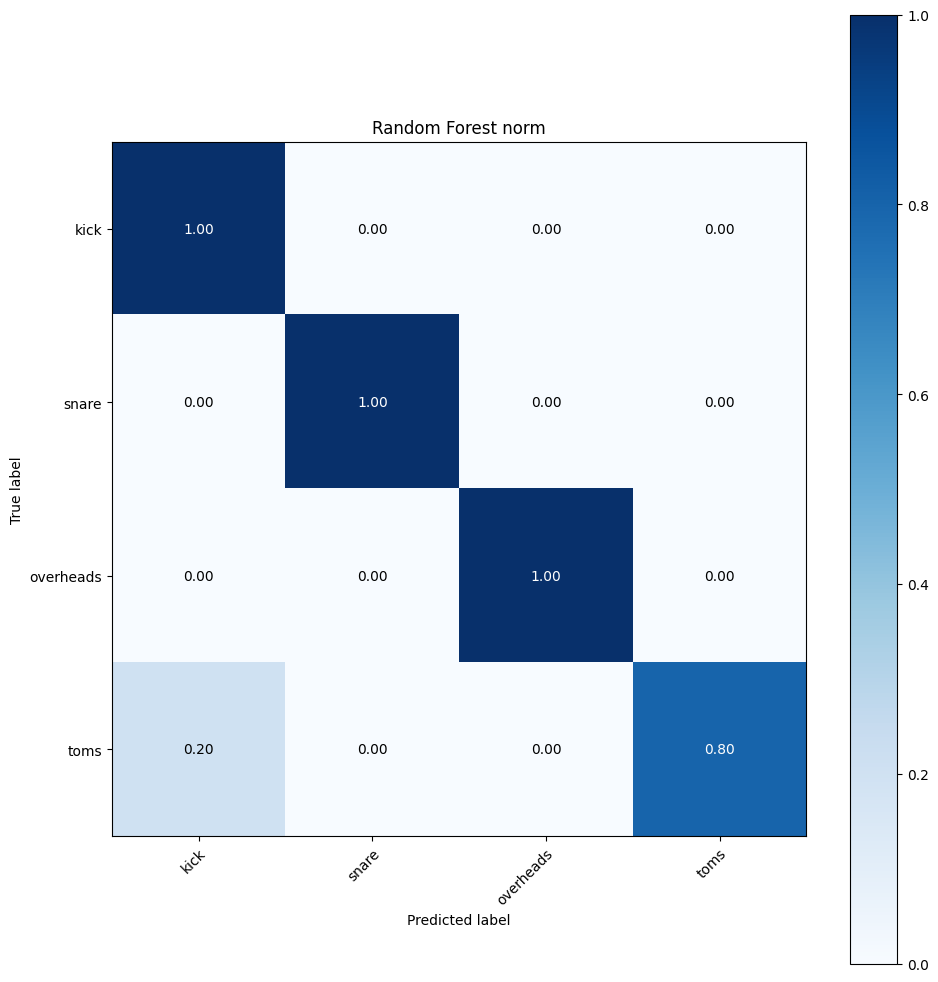

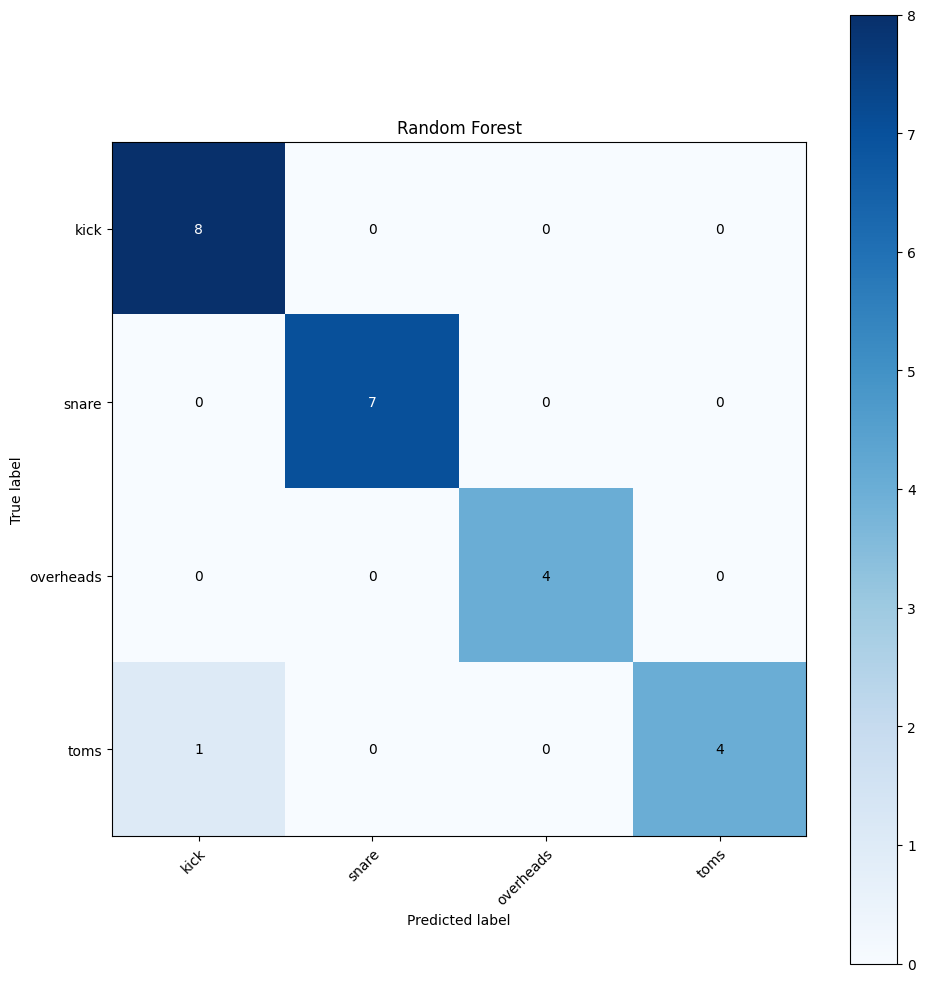

In [98]:
classes = df_labels['class'].value_counts(dropna=False).index.values

plot_confusion_matrix(Y_pred_svm, Y_test, classes=df_labels['class'].value_counts(dropna=False).index.values, normalize=True, title='Random Forest norm')
plot_confusion_matrix(Y_pred_svm, Y_test, classes=df_labels['class'].value_counts(dropna=False).index.values, normalize=False, title='Random Forest')

## **Visualization**

In [8]:
min_max_scaler = preprocessing.MinMaxScaler()
X_norm = min_max_scaler.fit_transform(X)

/var/folders/gk/fht8lvsx7yj3ch95mbx5tdwm0000gn/T/ipykernel_3583/734454673.py:6: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


<Axes: >

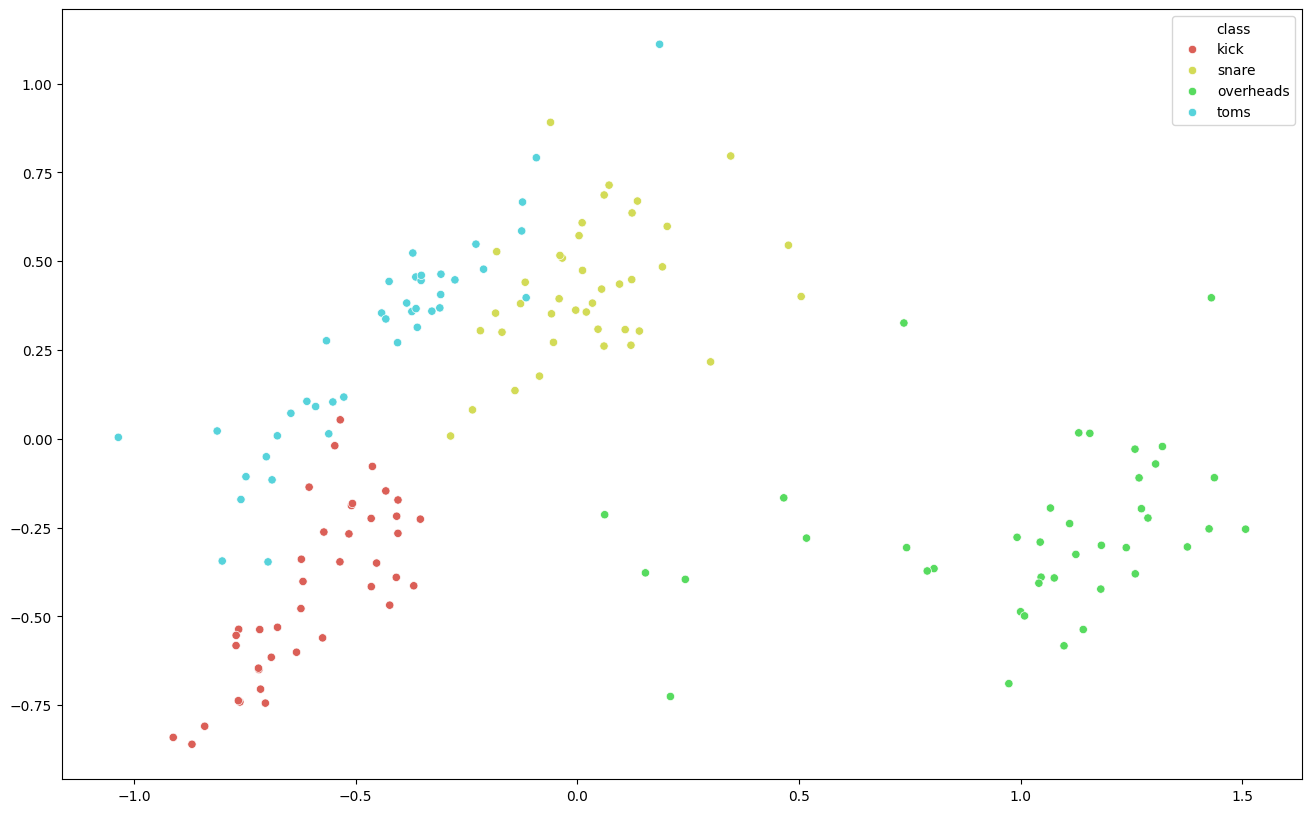

In [9]:
# PCA
pca_vis = PCA(n_components=2)
X_pca = pca_vis.fit_transform(X_norm)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=df_labels.iloc[:,2],
    palette=sns.color_palette("hls"),
    legend="full",
)


/var/folders/gk/fht8lvsx7yj3ch95mbx5tdwm0000gn/T/ipykernel_3583/698694856.py:7: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


<Axes: >

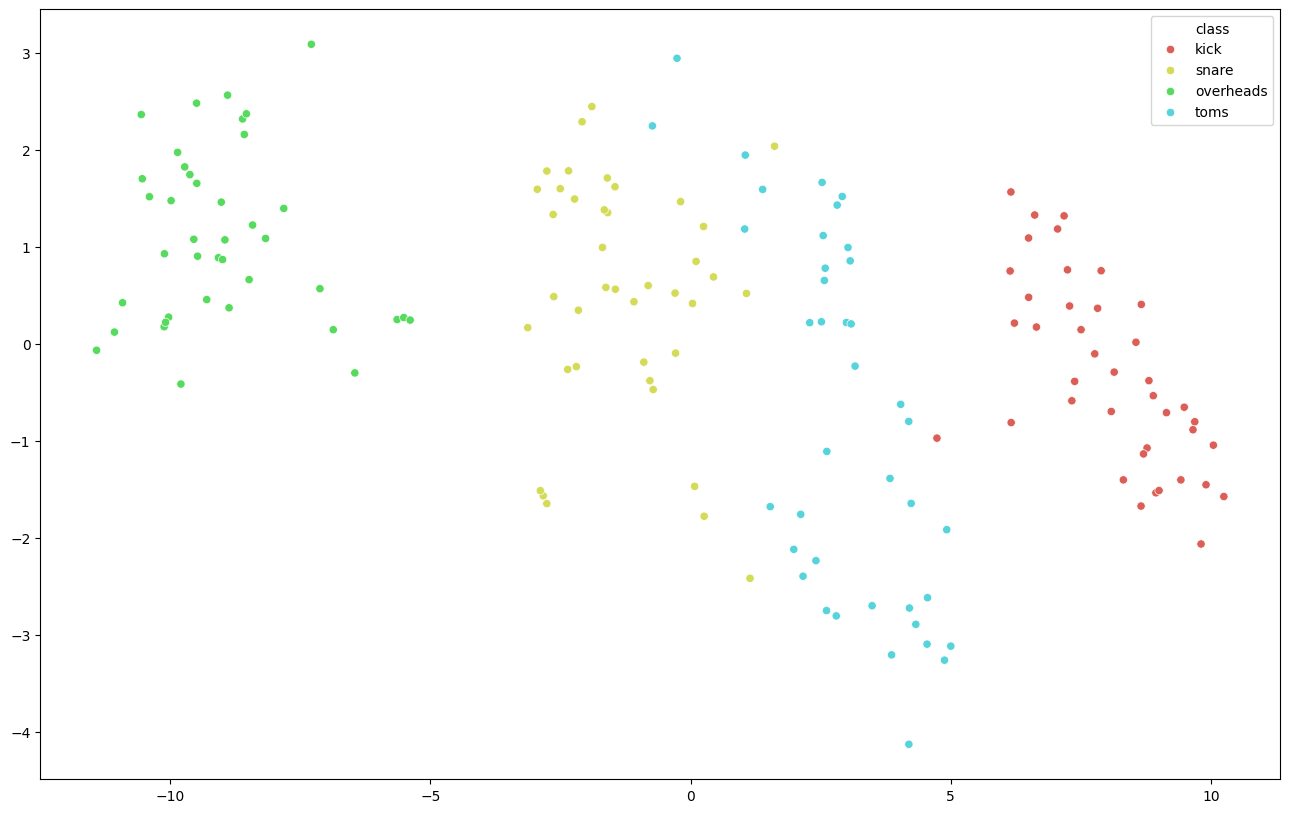

In [13]:
# T-SNE

tsne = TSNE(n_components=2, learning_rate='auto', init="random", perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_norm)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=df_labels.iloc[:,2],
    palette=sns.color_palette("hls"),
    legend="full",
)


In [33]:
X_norm

array([[0.        , 0.        , 0.03144735, ..., 0.38411778, 0.42832275,
        0.        ],
       [0.05236114, 0.59544389, 0.11910175, ..., 0.06761941, 0.08487953,
        0.47692411],
       [0.0091544 , 0.18837839, 0.02111759, ..., 0.11830162, 0.15452877,
        0.36521219],
       ...,
       [0.11941217, 0.75881118, 0.1443335 , ..., 0.01720926, 0.00476308,
        0.53166755],
       [0.10631844, 0.66900905, 0.12416367, ..., 0.08792535, 0.        ,
        0.51186433],
       [0.05925691, 0.26274952, 0.1497171 , ..., 0.14762457, 0.32207191,
        0.26491785]])